# Basic free recall analysis

This demo uses sample data from Morton et al. 2013. Participants completed 48 lists of 24 words each. Items were drawn from 3 categories: celebrities, landmarks, and objects. Lists were either "pure" (all the same category) or "mixed" (8 items from each category). Mixed lists had blocks of items from the same category, with length 2-6. Each of 3 sessions had 10 mixed lists and 6 pure lists (2 from each category).

Raw data are in a CSV file, which includes all study events (i.e., item presentations) and all recall events (i.e., attempted recalls). The main required fields are `trial_type` and `position`. The `trial_type` field indicates whether each trial is 'study' or 'recall'. For study events, the `position` field indicates input position (AKA serial position). For recall events, the `position` field indicates output position (that is, recall order).

## Load free recall data

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import importlib

module_path = '/Users/morton/PycharmProjects/psifr'
if module_path not in sys.path:
    sys.path.append(module_path)
from psifr import fr
data_file = os.path.join(module_path, 'data', 'cfr_raw_data.csv')

The `check_data` will run some basic checks to see if the data are formatted in the standard way. This will test if you can run psifr functions with the default settings. If the data have differently named fields, can still run the functions by setting the various `_keys` parameters. However, generally it's easiest to just standardize the column names at the beginning so you don't have to customize the key parameters.

In [2]:
df = pd.read_csv(data_file, dtype={'category': 'category'})
df.category.cat.as_ordered(inplace=True)
fr.check_data(df)

## Merge study and recall events

The study and recall events are stored in separate rows, but most analyses require cross-referencing the study and recall lists. Our first step, then, is to merge these events together.

By default, study and recall events with the same subject, list, and item will be merged. All combinations within that will be kept. The `subject`, `list`, `position`, `trial_type`, and `item` columns determine how events are merged. Other fields, such as the `category` and `list_type` fields here, will also be kept in the merged data. This allows you to specify any experiment-specific information you want in your data CSV file; it will be included in the merged data and can be used for analysis.

If an item is recalled once, then one study event will be matched with one recall event and will be labeled with `recalled=True`. If an item is incorrectly recalled multiple times, then one study event will be matched with two recall events, and the second one will be labeled with `repeat=1` (both events will still have `recalled=True`). Subsequent repeats of the same item will have `repeat=2`, `repeat=3`, etc. If an item not in the list is recalled, then there will be one recall event with no corresponding study event and this event will be labeled with `intrusion=True`.

In [3]:
# list_keys sets fields that should be defined even for recall
# events that don't match any of the study events for that list
data = fr.merge_lists(df, list_keys=['session', 'list_type'])

# sort events in standard order
data = data.sort_values(['subject', 'list', 'input']).reset_index(drop=True)

### View information about a sample list

To make it easier to understand the results of the merge, let's look at one sample list. First, we will view it with the default sorting by input position (AKA serial position). Items with no input position (i.e., intrusions) are placed at the end.

In [4]:
# cannot use query here, as that fails when referring to the list field
list1 = data.loc[(data['subject'] == 1) & (data['list'] == 37)]
list1

,subject,list,input,item,session,list_type,category,response,response_time,output,repeat,recalled,intrusion
888,1,37,1.0,LAWN MOWER,3,pure,obj,2.0,0.898,7.0,0,True,False
889,1,37,2.0,HANDCUFFS,3,pure,obj,2.0,0.602,NaN,0,False,False
890,1,37,3.0,CAMERA,3,pure,obj,2.0,0.726,NaN,0,False,False
891,1,37,4.0,GLASS,3,pure,obj,3.0,0.740,NaN,0,False,False
892,1,37,5.0,SAUCEPAN,3,pure,obj,4.0,1.004,NaN,0,False,False
893,1,37,6.0,CACTUS,3,pure,obj,1.0,1.101,NaN,0,False,False
894,1,37,7.0,KEYS,3,pure,obj,4.0,1.084,11.0,0,True,False
895,1,37,8.0,PIE,3,pure,obj,2.0,0.908,NaN,0,False,False
896,1,37,9.0,CANDLE,3,pure,obj,3.0,0.786,NaN,0,False,False
897,1,37,10.0,DRESSER,3,pure,obj,4.0,0.723,6.0,0,True,False


Because the list is represented as a merged table with both study and recall information, can also easily sort items by output position to order the rows in terms of the recall sequence.

This makes it easier to see that there were 14 correct recalls, followed by an intrusion of an item that was not in the list (BELT) and a repeat of an item that was already recalled (WATCH). Items thare were not recalled are still there, but are placed at the end because they have no defined output position (here, represented as NaN).

In [5]:
list1.sort_values('output')

,subject,list,input,item,session,list_type,category,response,response_time,output,repeat,recalled,intrusion
911,1,37,24.0,WATCH,3,pure,obj,3.0,0.947,1.0,0,True,False
909,1,37,22.0,SKATEBOARD,3,pure,obj,1.0,1.062,2.0,0,True,False
905,1,37,18.0,KNIFE,3,pure,obj,3.0,1.005,3.0,0,True,False
904,1,37,17.0,TROPHY,3,pure,obj,4.0,0.690,4.0,0,True,False
910,1,37,23.0,VASE,3,pure,obj,2.0,0.771,5.0,0,True,False
897,1,37,10.0,DRESSER,3,pure,obj,4.0,0.723,6.0,0,True,False
888,1,37,1.0,LAWN MOWER,3,pure,obj,2.0,0.898,7.0,0,True,False
906,1,37,19.0,INTERCOM,3,pure,obj,4.0,0.935,8.0,0,True,False
898,1,37,11.0,MODEM,3,pure,obj,4.0,1.019,9.0,0,True,False
902,1,37,15.0,BARCODE SCANNER,3,pure,obj,4.0,0.850,10.0,0,True,False


## Analyze recall performance

While all recall attempts are represented in the merged events, often will want just the "clean" events that exclude repeats and intrusions. This is simple using the pandas `query` method. Can then easily calculate summary statistics such as recall percentage for each subject using `groupby` with summary statistics supported by pandas. This method easily deals with lists that vary in length; recall performance is calculated separately for each list, and the length of that specific list is taken into account when calculating the average.

Filtering the data is important for calculating recall performance. If repeat or intrusion events are included, then taking the mean of the `recalled` field will give the fraction of all events that are correct recall events. This is different than what we generally want, that is, the fraction of items correctly recalled.

For example, using the "clean" events, we can quickly calculate mean recall performance by list type (pure or mixed) and category.

In [6]:
clean = data.query('repeat == 0 and ~intrusion')
perf = clean.groupby(['subject', 'category', 'list_type'])['recalled'].mean()

To print a table with basic statistics, can first "unstack" the data. This places the list type and category indices on the columns. Then, we can use the `agg` method to calculate statistics for each column, for example mean and standard error of the mean.

In [7]:
perf.unstack('list_type').unstack('category').agg(['mean', 'sem'])

mixed                          pure                    
           cel       loc       obj       cel       loc       obj
mean  0.540833  0.495729  0.455312  0.493750  0.499306  0.523264
sem   0.021941  0.020869  0.020320  0.020134  0.020357  0.018106

Using Seaborn, we can visualize the same results. When using `groupby`, pandas will return results with a `MultiIndex`. Seaborn, however, requires us to have columns, not indices, for every variable we want to use. We can fix this using `reset_index` when passing data into Seaborn.

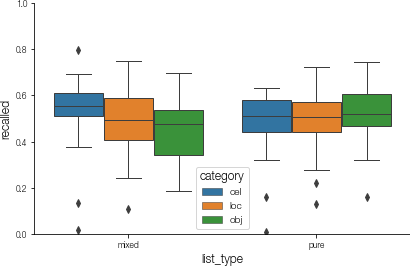

In [8]:
g = sns.boxplot(x='list_type', y='recalled', hue='category', dodge=True,
                data=perf.reset_index())
g.set_ylim(0, 1);

### Calculate recall by list

Using pandas and seaborn, once the data are in shape we can run simple analyses with very little code. This involves specifying how to group the data and which variables we want to plot.

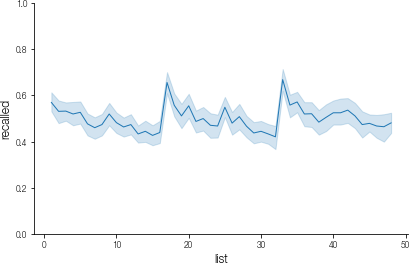

In [9]:
# calculate average recall by subject and list
perf = clean.groupby(['subject', 'list'])['recalled'].mean()

# plot with 95% confidence of the mean over subjects
g = sns.lineplot(x='list', y='recalled', data=perf.reset_index());
g.set_ylim(0, 1);

### Recall by list type and serial position

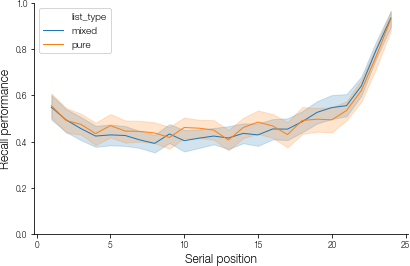

In [10]:
rec_pos = clean.groupby(['subject', 'list_type', 'input'])['recalled'].mean()
g = sns.lineplot(x='input', y='recalled', hue='list_type', data=rec_pos.reset_index());
g.set_ylim(0, 1);
g.set_xlabel('Serial position');
g.set_ylabel('Recall performance');

### Recall by list type, category, and serial position

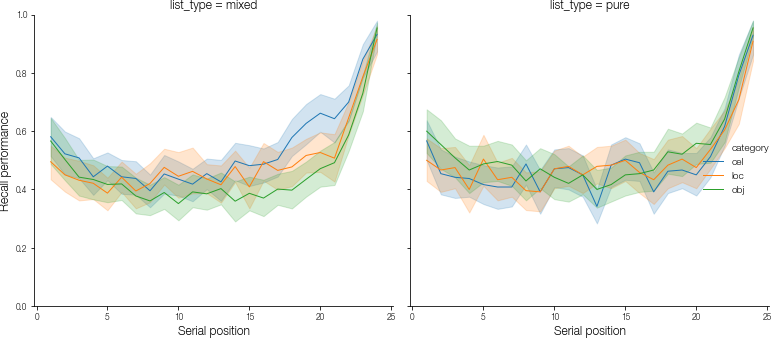

In [11]:
rec = clean.groupby(['subject', 'list_type', 'category', 'input'])['recalled'].mean()
g = sns.relplot(kind='line', x='input', y='recalled', col='list_type', 
                hue='category', data=rec.reset_index());
g.set(ylim=(0, 1));
g.set_axis_labels('Serial position', 'Recall performance');

### Recall by serial position for each participant

Seaborn makes visualization of "small multiples" (that is, simple plots viewed for multiple subsets of the data) easy. For example, can quickly get a sense of individual differences by plotting the serial position curve separately for each subject.

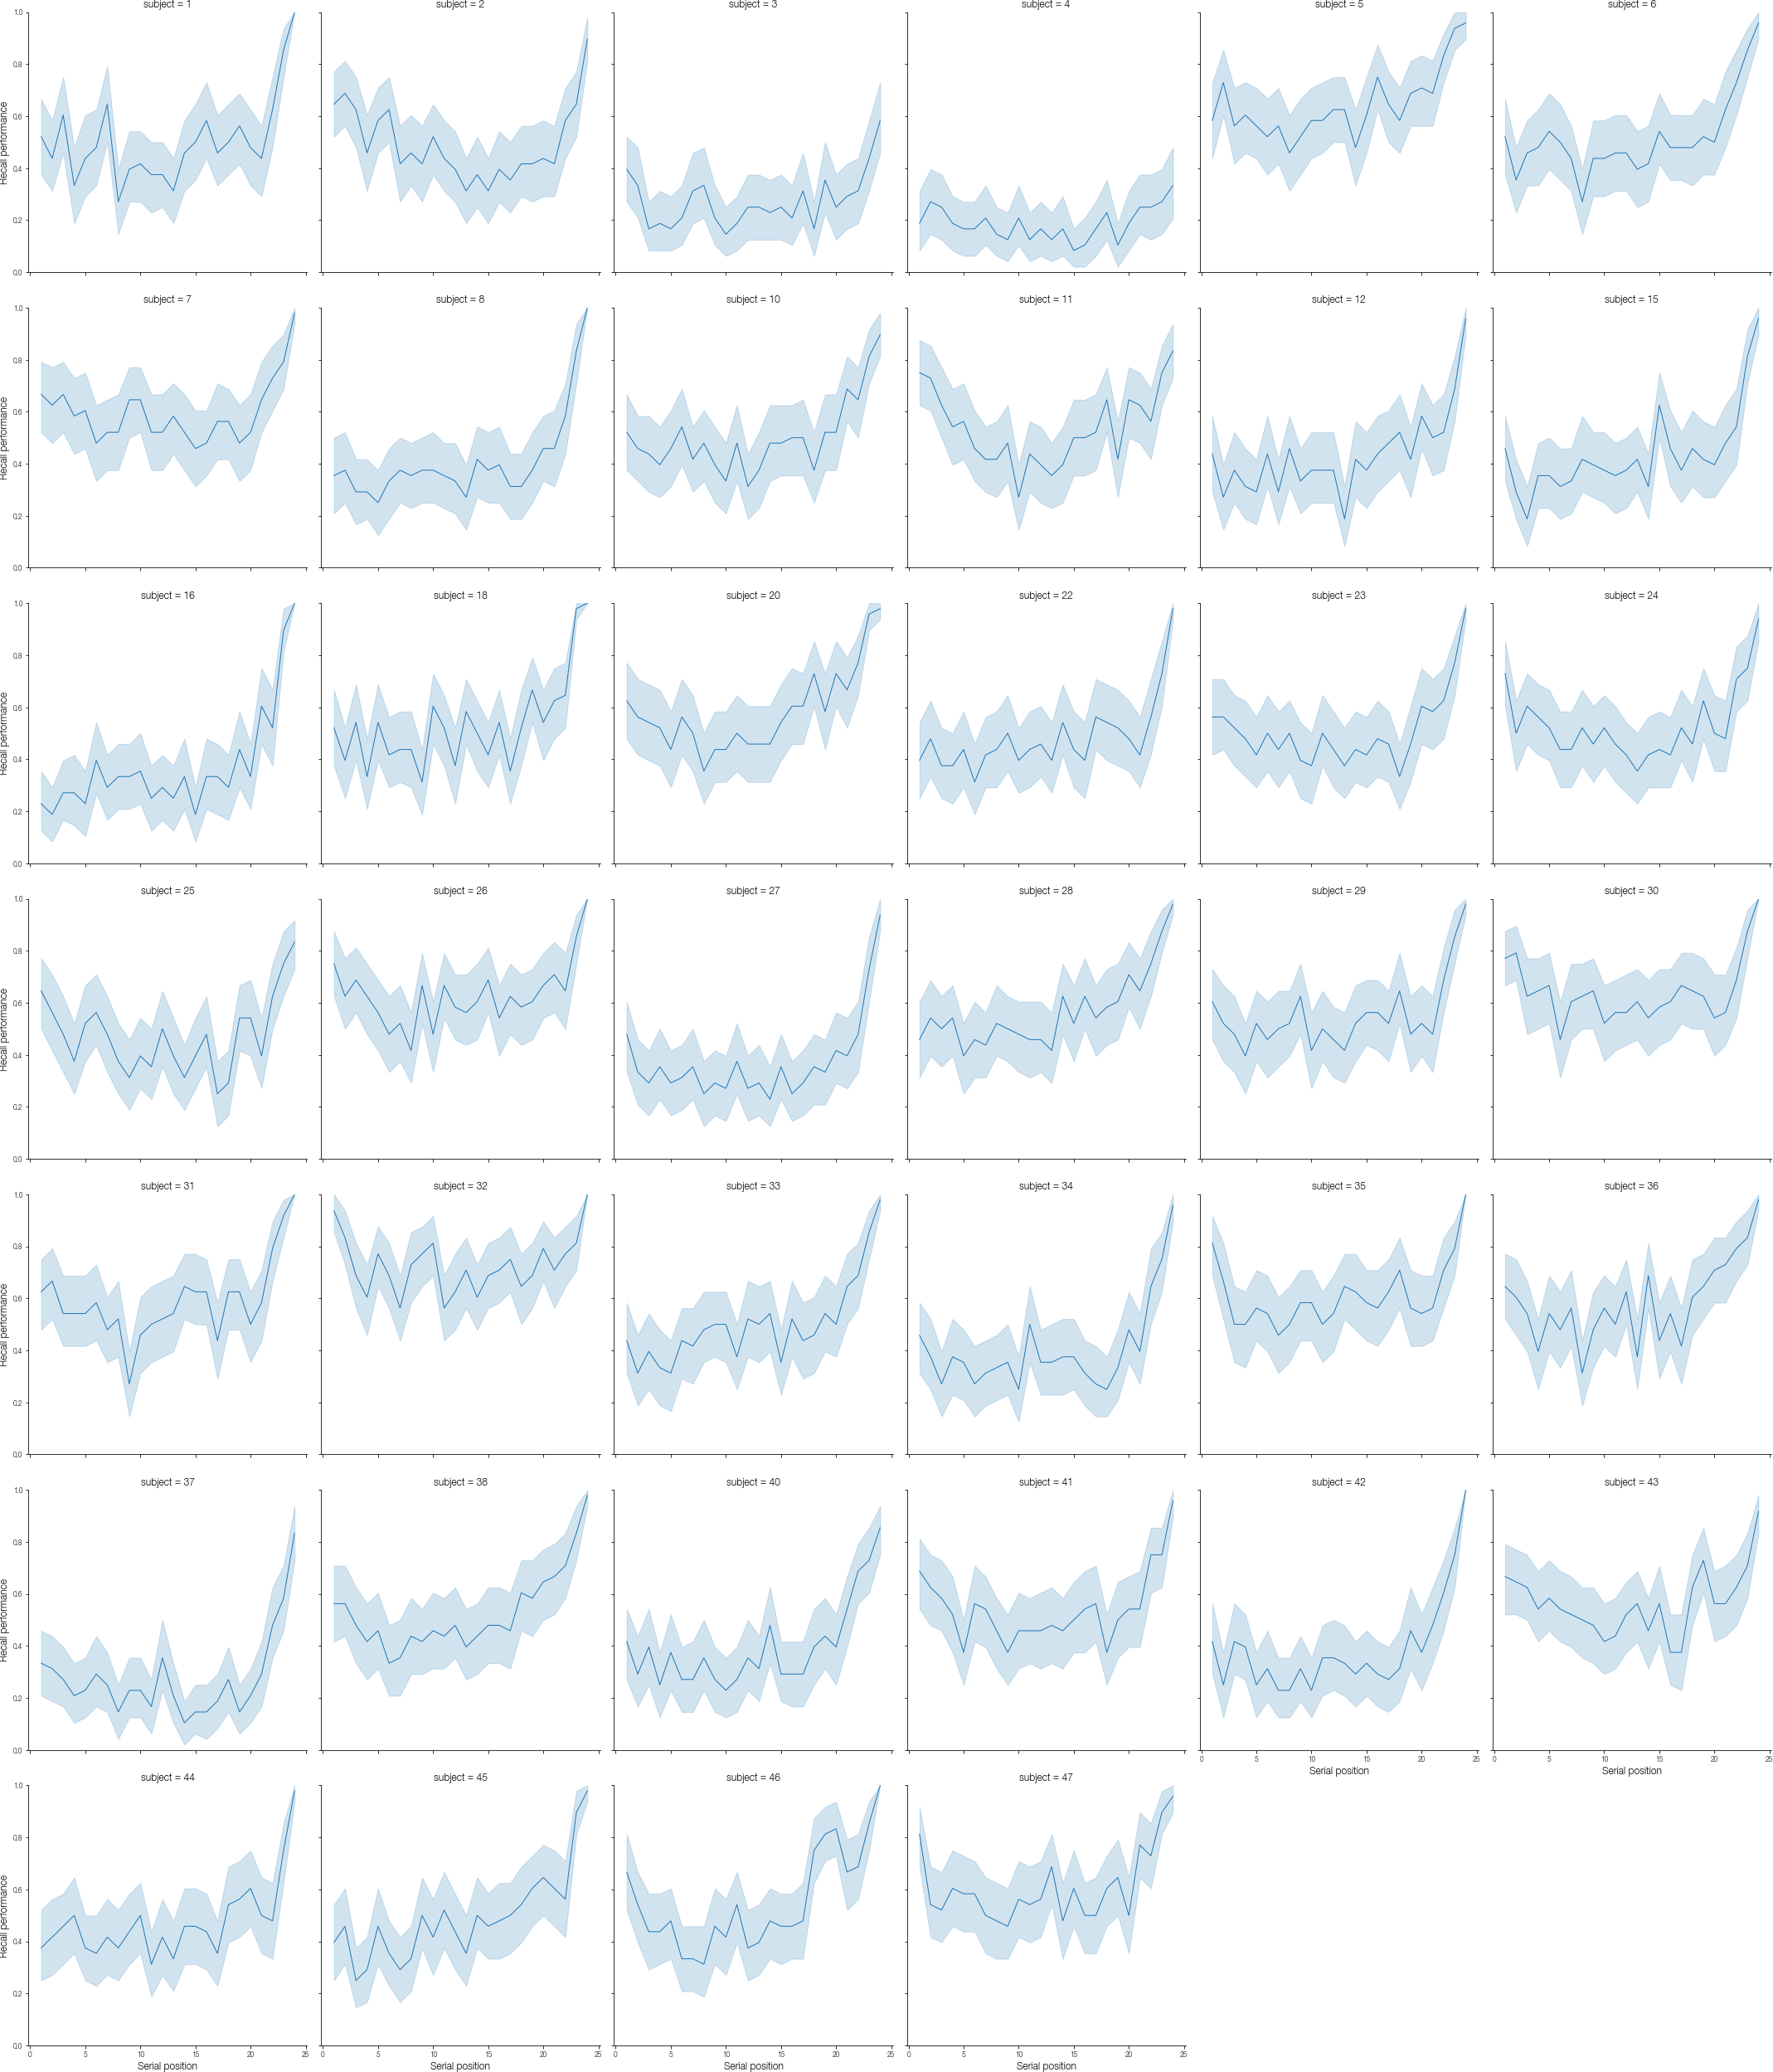

In [12]:
g = sns.relplot(kind='line', x='input', y='recalled', 
                col='subject', col_wrap=6, 
                data=clean.reset_index());
g.set(ylim=(0, 1));
g.set_axis_labels('Serial position', 'Recall performance');

In [13]:
def group_by_train(list1):
    prev_category = ''
    curr_train = 0
    train = np.zeros(list1.shape[0], dtype=int)
    for i, trial in list1.reset_index().iterrows():
        if prev_category != trial.category:
            curr_train += 1
        train[i] = curr_train
        prev_category = trial.category
    return train

group_by_train(list1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2])